In [2]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
import util

### Read in the image

99.2244897959
99.2448979592


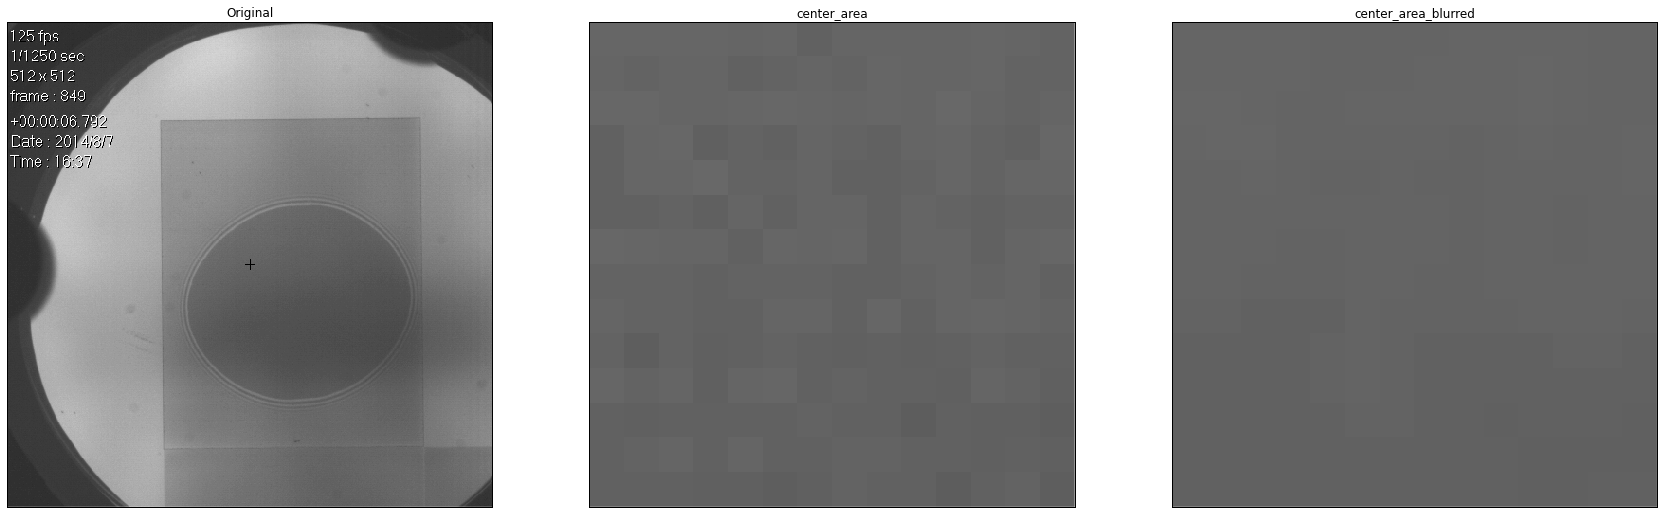

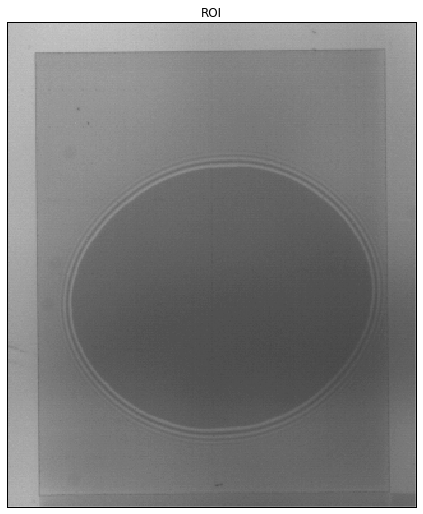

In [3]:
#img = cv2.imread('/data/projects/contact_front/EFF/ContactFront-040.png',cv2.IMREAD_COLOR)
#img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.imread('/data/projects/contact_front/EFF/ContactFront-040.png',cv2.IMREAD_GRAYSCALE)
rows, cols = img.shape

img_annotate = img.copy()
midX, midY = cols/2, rows/2
center_area = img[midY-7:midY+7, midX-7:midX+7]
center_area_blurred = cv2.GaussianBlur(center_area, (3, 3), 0)

#img_roi = img[99:449, 170:440]
img_roi = img[80:460, 140:460]

green = (0, 255, 0)
cv2.line(img_annotate, (midY, midX-5), (midY, midX+5), green)
cv2.line(img_annotate, (midY-5, midX), (midY+5, midX), green)
#cv2.rectangle(img, (midY-7, midX-7), (midY+7, midX+7), green)

print center_area.mean()
print center_area_blurred.mean()

util.plot_imgs([(img_annotate,'Original'), (center_area, 'center_area'), 
            (center_area_blurred, 'center_area_blurred'), (img_roi, 'ROI')])

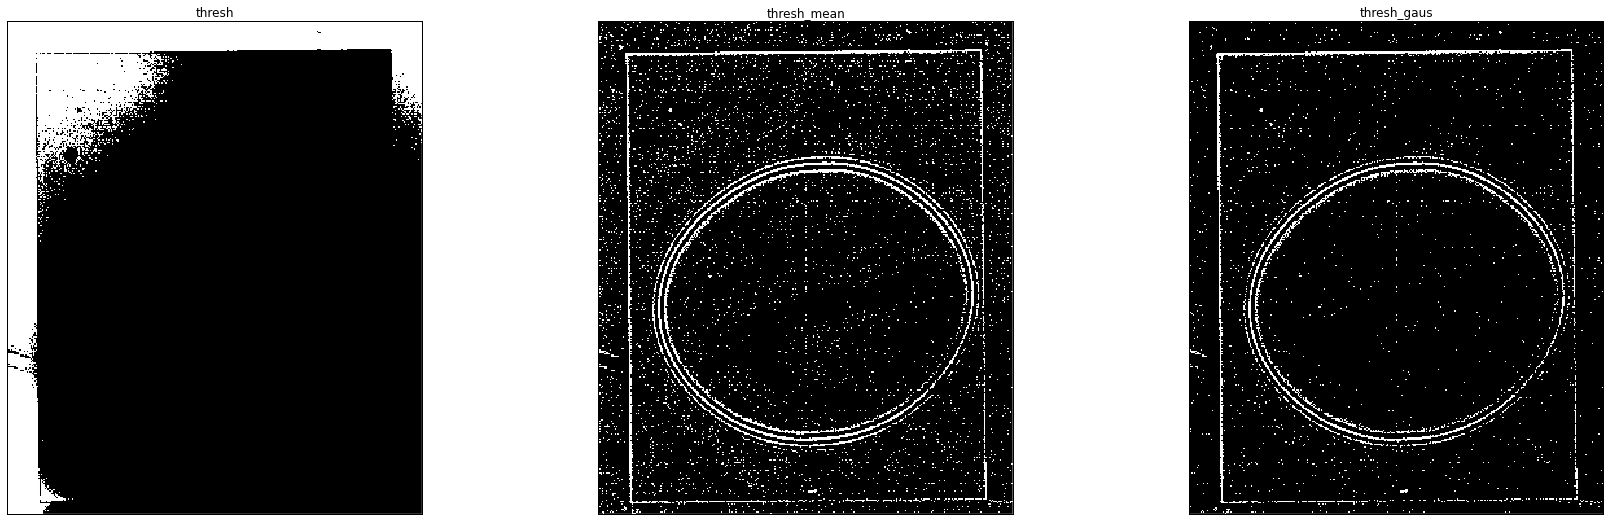

In [4]:
retval, thresh = cv2.threshold(img_roi, 145, 255, cv2.THRESH_BINARY)

blurred = cv2.GaussianBlur(img_roi, (7, 7), 0)
#burred = img

thresh_mean = cv2.adaptiveThreshold(img_roi, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 7, 4)
thresh_gaus = cv2.adaptiveThreshold(img_roi, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 4)

util.plot_imgs([(thresh, 'thresh'), (thresh_mean, 'thresh_mean'), (thresh_gaus, 'thresh_gaus')])

In [5]:

# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 70;
params.maxThreshold = 110;
 
# Filter by Area.
# params.filterByArea = True
# params.minArea = 1500
 
# Filter by Circularity
# params.filterByCircularity = True
# params.minCircularity = .1
 
# # Filter by Convexity
# params.filterByConvexity = True
# params.minConvexity = 0.87
 
# # Filter by Inertia
# params.filterByInertia = True
# params.minInertiaRatio = 0.9
 
detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs.
keypoints = detector.detect(img[102:449, 163:440])
print len(keypoints)

if len(keypoints):
    # Draw detected blobs as red circles.
    # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
    im_with_keypoints = cv2.drawKeypoints(img, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Show keypoints
    util.plot_imgs([(im_with_keypoints,'Keypoints')])

0


In [6]:
laplacian = cv2.Laplacian(img,cv2.CV_64F)
laplacian = np.uint8(np.absolute(laplacian))
sobelX = cv2.Sobel(img,cv2.CV_64F, 1, 0, ksize=3)
sobelX = np.uint8(np.absolute(sobelX))
sobelY = cv2.Sobel(img,cv2.CV_64F, 0, 1, ksize=3)
sobelY = np.uint8(np.absolute(sobelY))
sobelCombined = cv2.bitwise_or(sobelX, sobelY)


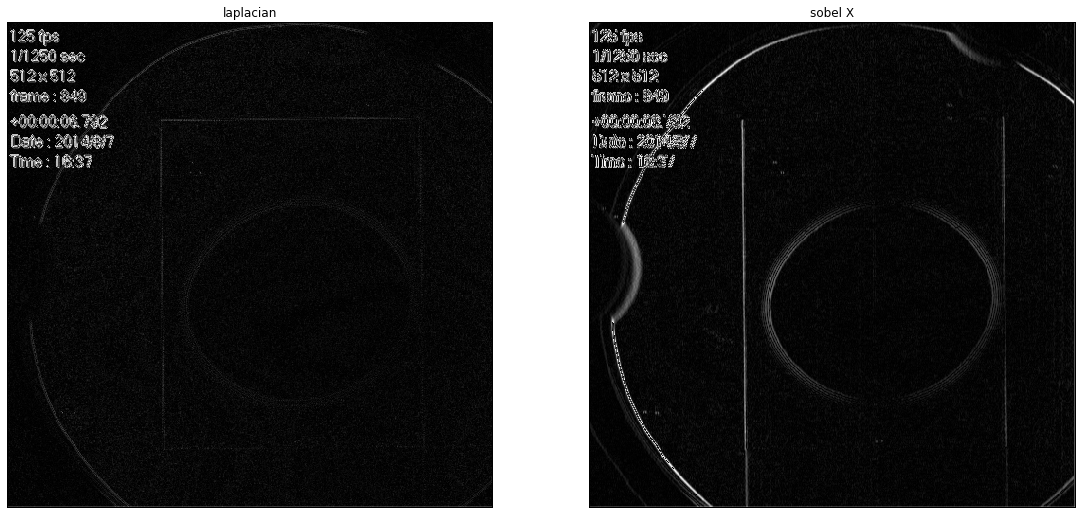

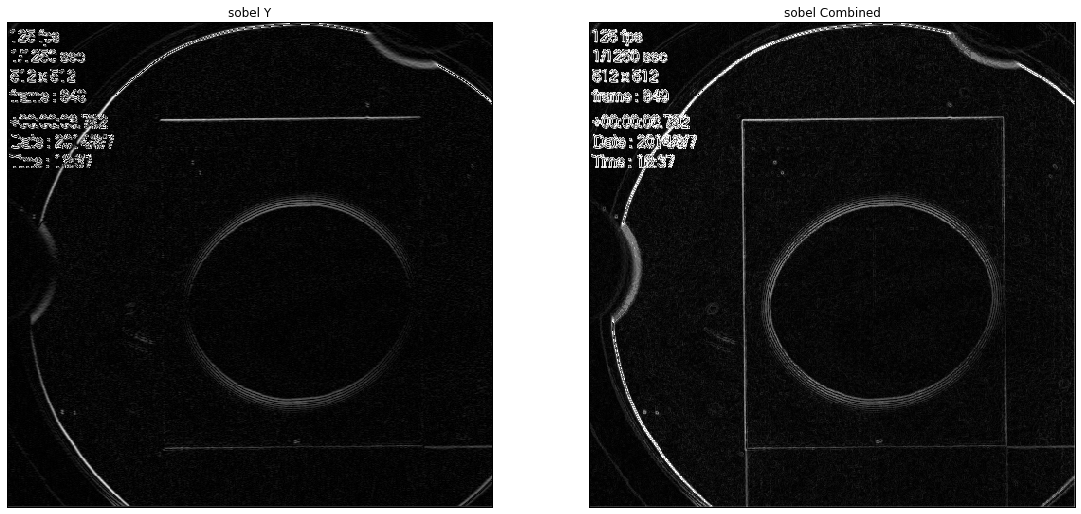

In [7]:
util.plot_imgs([(laplacian,'laplacian'), (sobelX, 'sobel X'), 
           (sobelY, 'sobel Y'), (sobelCombined, 'sobel Combined')], max_cols=2)

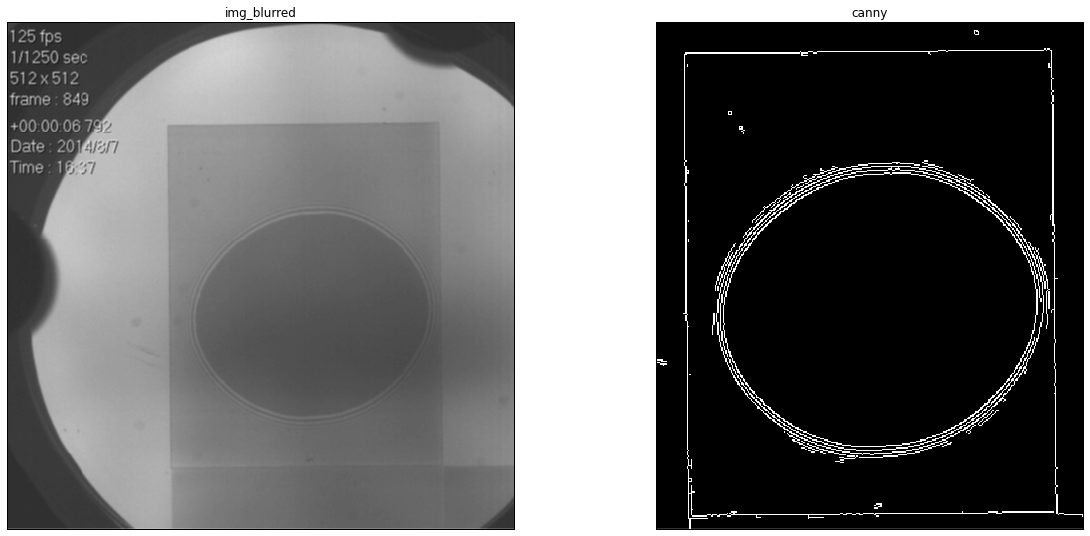

In [8]:
img_blurred = cv2.GaussianBlur(img, (3, 3), 0)
#img_blurred = cv2.bilateralFilter(img, 11, 17, 17)
canny = cv2.Canny(img_roi, 20, 60, apertureSize=3, L2gradient=True)

util.plot_imgs([(img_blurred,'img_blurred'), (canny,'canny')])

### Now try to find features

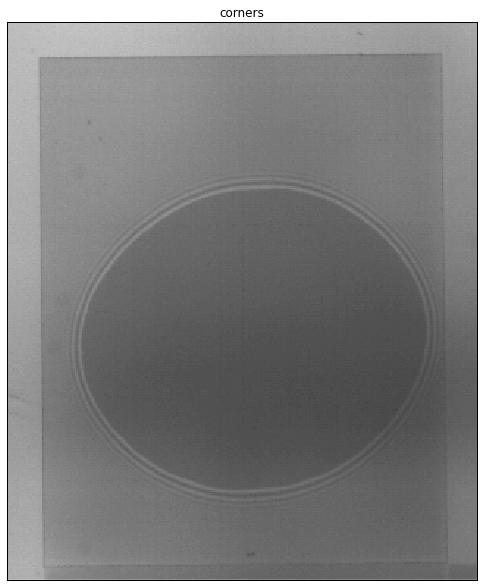

In [9]:
# corners = cv2.goodFeaturesToTrack(img_roi,10,0.1,300)
# corners = np.int0(corners)

# for i in corners:
#     x,y = i.ravel()
#     cv2.circle(img_roi,(x,y),3,255,-1)

sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(img_roi,None)

cv2.drawKeypoints(img_roi,kp, img_roi)

util.plot_imgs([(img_roi,'corners')])

0.0451855752861
0.0
0.0
0.788462265821
0.0
0.671341013873
6


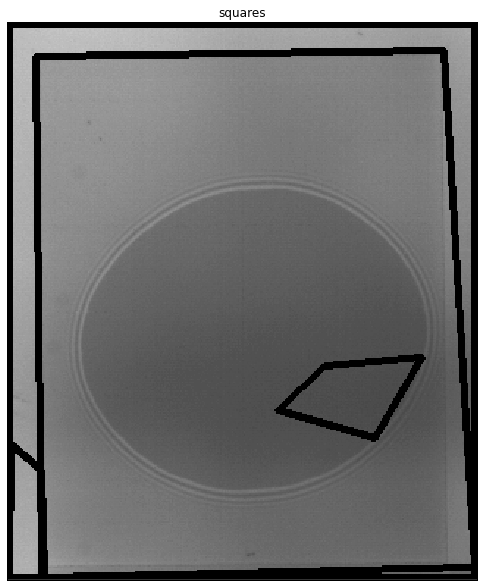

In [10]:
def angle_cos(p0, p1, p2):
    d1, d2 = (p0-p1).astype('float'), (p2-p1).astype('float')
    return abs( np.dot(d1, d2) / np.sqrt( np.dot(d1, d1)*np.dot(d2, d2) ) )

def find_squares(img):
    #img = cv2.GaussianBlur(img, (3, 3), 0)
    squares = []
    for gray in cv2.split(img_roi):
        for thrs in xrange(0, 255, 26):
            if thrs == 0:
                #bin = cv2.Canny(gray, 0, 50, apertureSize=5)
                bin = cv2.Canny(img, 10, 60, apertureSize=3, L2gradient=True)
                bin = cv2.dilate(bin, None)
            else:
                retval, bin = cv2.threshold(gray, thrs, 255, cv2.THRESH_BINARY)
            bin, contours, hierarchy = cv2.findContours(bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
            for cnt in contours:
                cnt_len = cv2.arcLength(cnt, True)
                cnt = cv2.approxPolyDP(cnt, 0.02*cnt_len, True)
                if len(cnt) == 4 and cv2.contourArea(cnt) > 1000 and cv2.isContourConvex(cnt):
                    cnt = cnt.reshape(-1, 2)
                    max_cos = np.max([angle_cos( cnt[i], cnt[(i+1) % 4], cnt[(i+2) % 4] ) for i in xrange(4)])
                    print max_cos
                    if max_cos < 1:
                        squares.append(cnt)
    return squares

squares = find_squares(canny)
print len(squares)
cv2.drawContours( img_roi, squares, -1, (0, 255, 0), 3 )
util.plot_imgs([(img_roi,'squares')])

Initial contours count: 52 
[0]  peri:  1946 vertices: 5
[1]  peri:   726 vertices: 8
[2]  peri:  2642 vertices: 15
[3]  peri:   225 vertices: 4
(181, 109, 91, 50) (181, 109) (91, 50)
[4]  peri:  2782 vertices: 8
[5]  peri:    43 vertices: 5
[6]  peri:    33 vertices: 5
[7]  peri:    16 vertices: 8
[8]  peri:    14 vertices: 6
[9]  peri:    13 vertices: 9
[10]  peri:    91 vertices: 9
[11]  peri:    14 vertices: 6
[12]  peri:    12 vertices: 8
[13]  peri:    12 vertices: 8
[14]  peri:    12 vertices: 6
[15]  peri:    11 vertices: 6
[16]  peri:    10 vertices: 6
[17]  peri:    10 vertices: 6
[18]  peri:    10 vertices: 6
[19]  peri:    10 vertices: 6


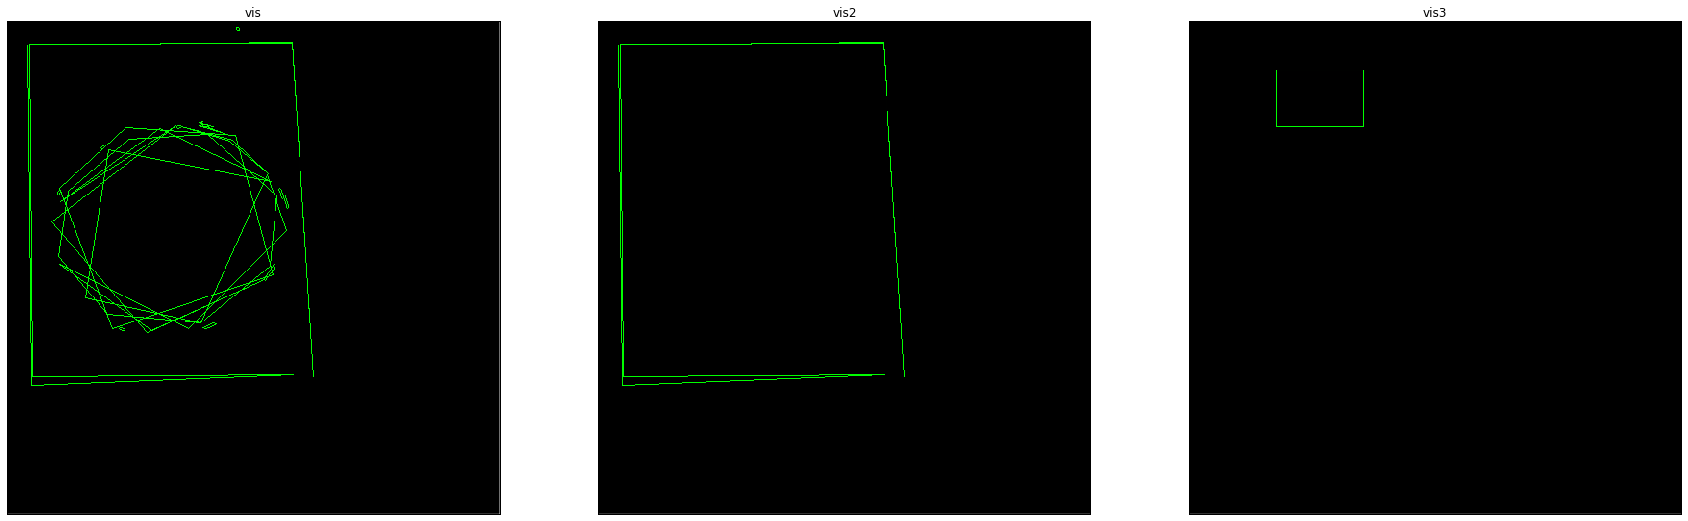

In [11]:
# (cnts, a,b) =cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# _, contours0, hierarchy = cv2.findContours( canny.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# contours = [cv2.approxPolyDP(cnt, 3, True) for cnt in contours0]

_, contours, hierarchy = cv2.findContours(canny.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
print "Initial contours count: %d " % (len(contours))
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:20]
screenCnt = None

contours2=[]
squares=[]
top_peri = 0

# loop over our contours
for idx, c in enumerate(contours):
    #M = cv2.moments(c)
    #print M
    
    # approximate the contour
    peri = cv2.arcLength(c, True)     
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    print "[%d]  peri: %5.f vertices: %d" % (idx, peri, len(approx))

    # if our approximated contour has four points, then
    # we can assume that we have found our screen
    if len(approx) >= 4:
        if peri > top_peri:
            top_peri = peri
            activeArea = approx
        contours2.append(approx)
        #break
    if len(approx) == 4:
        square = cv2.boundingRect(approx)
        print square[0:4], square[0:2], square[2:4]

#print hierarchy[0]

h, w = img.shape[:2]
vis = np.zeros((h, w, 3), np.uint8)
vis2 = np.zeros((h, w, 3), np.uint8)
vis3 = np.zeros((h, w, 3), np.uint8)

#cv2.drawContours(vis, [screenCnt], -1, (0, 255, 0), 3)
cv2.drawContours(vis, contours2, -1, (0, 255, 0), 1)
cv2.drawContours(vis2, [activeArea], -1, (0, 255, 0), 1)

if len(square) >0:
    cv2.rectangle(vis3, square[0:2], square[2:4], green, 1)

if False:
    levels=1
    cv2.drawContours( vis, contours, (-1, 3)[levels <= 0], (128,255,255),
        3, cv2.LINE_AA, hierarchy, abs(levels) )

util.plot_imgs([(vis,'vis'), (vis2,'vis2'), (vis3,'vis3')])

Initial contours count: 52 
[0]  peri  : 1945.606331
[1]  peri  : 726.423442
[2]  peri  : 2641.686627
[3]  peri  : 225.178713
[4]  peri  : 2782.399057
[5]  peri  : 43.112698
[6]  peri  : 32.970562
[7]  peri  : 16.485281
[8]  peri  : 14.485281
[9]  peri  : 13.071068
(169.5, 196.5)
234.443252563


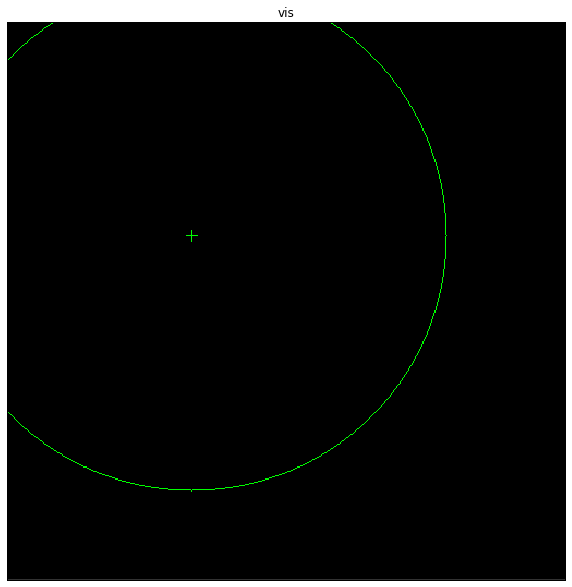

In [12]:
#(cnts, a,b) =cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# _, contours0, hierarchy = cv2.findContours( canny.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# contours = [cv2.approxPolyDP(cnt, 3, True) for cnt in contours0]

_, contours, hierarchy = cv2.findContours(canny.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
print "Initial contours count: %d " % (len(contours))
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
screenCnt = None


contours2=[]
top_peri = 0

# loop over our contours
for idx, c in enumerate(contours):
    #M = cv2.moments(c)
    #print M
    
    # approximate the contour
    peri = cv2.arcLength(c, True)
    print "[%d]  peri  : %f" % (idx, peri)
            
    approx = cv2.approxPolyDP(c, 0.002 * peri, True)
    contours2.append(approx)

    if peri > top_peri:
        top_peri = peri
        top_contour = approx

    # if our approximated contour has four points, then
    # we can assume that we have found our screen
    if len(approx) == 4:
        screenCnt = approx
        break

#print hierarchy[0]

h, w = img.shape[:2]
vis = np.zeros((h, w, 3), np.uint8)

#cv2.drawContours(vis, [screenCnt], -1, (0, 255, 0), 3)
#cv2.drawContours(vis, contours2, -1, (0, 255, 0), 1)
#cv2.drawContours(vis, [top_contour], -1, (0, 255, 0), 1)

center, rad = cv2.minEnclosingCircle(top_contour)
print center
print rad
center = int(center[0]), int(center[1])
rad = int(rad)
cv2.circle(vis, center, rad, green)
cv2.line(vis, (center[0], center[1]-5), (center[0], center[1]+5), green)
cv2.line(vis, (center[0]-5, center[1]), (center[0]+5, center[1]), green)


if False:
    levels=1
    cv2.drawContours( vis, contours, (-1, 3)[levels <= 0], (128,255,255),
        3, cv2.LINE_AA, hierarchy, abs(levels) )

util.plot_imgs([(vis,'vis')])

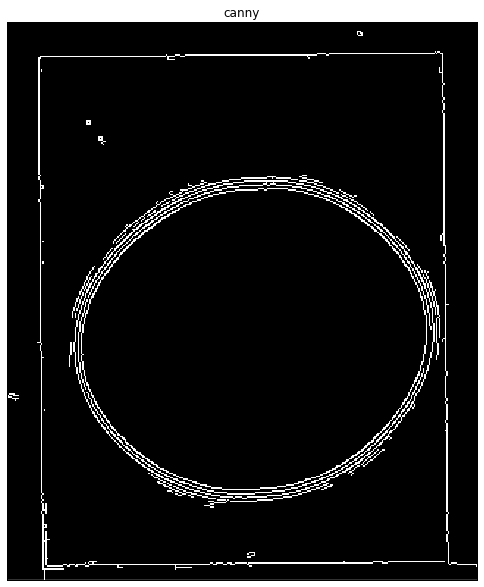

In [13]:
util.plot_imgs([(canny,'canny')])

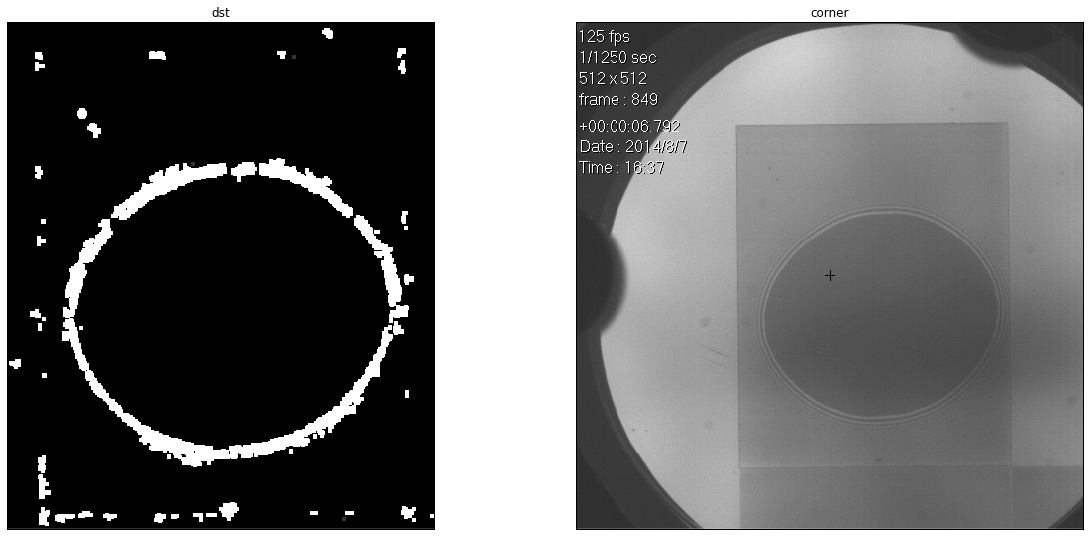

In [14]:
gray = np.float32(canny)
dst = cv2.cornerHarris(gray,2,7,0.04)

#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)

# Threshold for an optimal value, it may vary depending on the image.
#img_annotate[dst>0.01*dst.max()]=[0,0,255]

util.plot_imgs([(dst,'dst'), (img_annotate,'corner')])

In [15]:
#img = cv2.medianBlur(img, 51)
# circles = cv2.HoughCircles(img_blurred,cv2.HOUGH_GRADIENT,1,20,
#                             param1=50,param2=30,minRadius=50,maxRadius=100)
# len(circles[0,:])
# circles = np.uint16(np.around(circles))

# for i in circles[0,:]:
#     # draw the outer circle
#     cv2.circle(img_blurred,(i[0],i[1]),i[2],(0,255,0),2)
#     # draw the center of the circle
#     cv2.circle(img_blurred,(i[0],i[1]),2,(0,0,255),3)

# plt.subplot(111),plt.imshow(img_blurred)
# plt.title('Hough Transform'), plt.xticks([]), plt.yticks([])
# plt.show()
